# Modéliser le nombre d'usagers du réseau Transilien

Olivier Viollet, Mars 2019, olivier.viollet[a]gmail.com

## Résumé 

Cette étude vise à modéliser le nombre d'usagers montants dans les trains du réseau Transilien. La précision du modèle est convenable dans la mesure où l'erreur moyenne représente environ 400 personnes mais que dans 50 % des cas l'erreur est inférieure à 50 usagers.  

## Préparation des données

Les données ont été mises à disposition sur la plateforme d'ouverture des données publiques du conseil régional d'Ile-de-France, dans leur version mise à jour le **27 avril 2018**. Elles sont accessibles à l'adresse suivante, ainsi qu'un dictionnaire des variables : https://data.iledefrance.fr/explore/dataset/voyageurs-montant-en-gare-sur-le-reseau-transilien/information/?sort=ligne

Le jeu de données contient **7152 observations**, ce qui est relativement peu, et les variables suivantes :

- nom (et code) de la gare du Transilien ;
- le type de jour : jour de semaine (JOB), Samedi, Dimanche ;
- les dates du comptage des montants ;
- la ligne du Transilien ;
- la tranche horaire du comptage ;
- le nombre d'usagers montants comptabilisés, qui constitue la **variable cible** dans cette étude.

La préparation des données a d'abord impliqué l'extraction de l'année, du mois et du jour de la semaine à partir de la colonne Date puis le recodage des valeurs Samedi et Dimanche en une valeur Weekend dans la colonne Type jour.

In [1]:
# extensions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, median_absolute_error

# fonction de recodage
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded

In [3]:
# charger les données
transilien = pd.read_csv('voyageurs-montant-en-gare-sur-le-reseau-transilien.csv', sep = ';', encoding = 'utf-8')
transilien.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7152 entries, 0 to 7151
Data columns (total 7 columns):
Nom gare            7152 non-null object
Code Gare           7152 non-null int64
Type jour           7152 non-null object
Date de comptage    7152 non-null object
Ligne               7152 non-null object
Tranche horaire     7152 non-null object
Montants            7152 non-null int64
dtypes: int64(2), object(5)
memory usage: 391.2+ KB


In [4]:
# extraire l'année, le mois et le jour de la semaine
transilien['Date de comptage'] = pd.to_datetime(transilien['Date de comptage'], utc = True)
transilien['Année'] = transilien['Date de comptage'].dt.year
transilien['Mois'] = transilien['Date de comptage'].dt.month
transilien['Jour_semaine'] = transilien['Date de comptage'].dt.dayofweek

transilien['Année'] = transilien['Année'].astype('category')
transilien['Mois'] = transilien['Mois'].astype('category')
transilien['Jour_semaine'] = transilien['Jour_semaine'].astype('category')
transilien['Jour_semaine'] = coding(transilien['Jour_semaine'], {1:'Mardi',3:'Jeudi',5:'Samedi',6:'Dimanche'})

In [5]:
# recoder des valeurs
#pd.value_counts(transilien['Type jour'])
transilien['Type jour'] = coding(transilien['Type jour'], {'Dimanche':'weekend', 'Samedi':'weekend'})
pd.value_counts(transilien['Type jour'])

weekend    4616
JOB        2536
Name: Type jour, dtype: int64

In [6]:
# supprimer des colonnes
transilien.drop(columns = ['Date de comptage'], inplace=True)

Le **grand nombre de gares** du réseau transilien ne permettrait pas de visualiser clairement les différences du nombre d'usagers en fonction de chacune. Cependant, il serait opportun de disposer dans le jeu de données d'une colonne distinguant, par exemple, les **gares parisiennes** des gares non parisiennes, certaines des premières, comme Saint-Lazare ou Châtelet, étant vraisemblablement celles dans lesquelles le nombre d'usagers est le plus élevé. C'est pourquoi nous recourons à un autre jeu de données disponible sur la plateforme de données ouvertes de la SNCF, accessible à l'adresse suivante : https://ressources.data.sncf.com/explore/dataset/sncf-gares-et-arrets-transilien-ile-de-france/information/?sort=libelle. 

Nous en fusionnons une partie avec le jeu de données initial afin d'obtenir des renseignements supplémentaires de type géographique : la commune de la gare ; la zone du pass Navigo de la gare. Certaines données étant manquantes suite à la fusion des deux jeux, nous leur imputons une valeur 'nd' pour 'non disponible', même s'il serait possible de les recoder manuellement. A partir de la ville de la gare, nous créons une variable binaire prenant la valeur 1 si la gare est parisienne, 0 autrement.

In [7]:
# importer le jeu de données comprenant des informations sur les gares
gares = pd.read_csv('sncf-gares-et-arrets-transilien-ile-de-france.csv', usecols = [0,9,13], sep = ';', encoding = 'utf-8')
gares.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 3 columns):
Code UIC       515 non-null int64
Commune        513 non-null object
Zone Navigo    515 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 12.1+ KB


In [8]:
# fusionner avec le jeu de données initial
gares.rename(columns = {'Code UIC' : 'Code Gare'}, inplace = True)
transilien = pd.merge(transilien, gares, how = 'left', on = 'Code Gare')
transilien['Zone Navigo'].fillna('nd', inplace = True)
transilien['Zone Navigo'] = coding(transilien['Zone Navigo'], {100:'nd'}) # 100 est une valeur absurde, sans doute pour désigner une valeur manquante
transilien['Zone Navigo'] = transilien['Zone Navigo'].astype('category')
transilien['Commune'].fillna('nd', inplace = True)

In [9]:
# créer une variable binaire : la gare est-elle à Paris ?
transilien['Commune'].fillna('nd', inplace = True)
transilien['Commune'] = coding(transilien['Commune'], {'Cormeilles-en-Parisis':'Cormeilles'}) # pour éviter de comptabiliser à tort cette ville dans les gares parisiennes
transilien['is_Paris'] = transilien['Commune'].str.count('Paris')
transilien.drop(columns = ['Commune','Code Gare'], inplace=True)

## Exploration des données

L'exploration des données fait apparaître les éléments suivants :

- l'année et le mois ne semblent pas fortement impacter le nombre de montants ;
- le jeudi comporte plus de valeurs extrêmes dans le sens d'un plus grand nombre de montants, tandis que le nombre d'usagers est nettement moins élevé le weekend, ce qui n'est pas étonnant ;
- les lignes E, B et D affichent une distribution comprenant un plus grand nombre de valeurs élevées du nombre de montants ;
- le nombre d'usagers est toujours très faible avant 6h du matin et, dans une moindre mesure, après 20h, tandis qu'il peut atteindre des sommets entre 16h et 20h ;
- comme attendu, le nombre d'usagers est bien plus élevé dans les gares parisiennes que dans les gares non-parisiennes, même si certaines de ces dernières comportent quelques valeurs très élevées ;
- le même constat ressort de la distinction par zone de pass Navigo, celle de Paris (1) comportant les valeurs les plus élevées, tandis que les plus éloignées, dans la zone 5, sont associées à moins d'usagers.


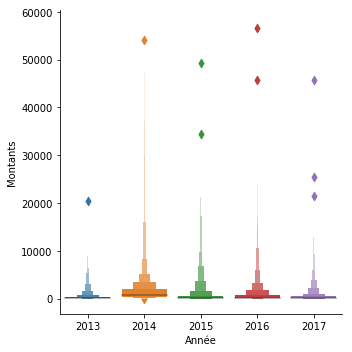

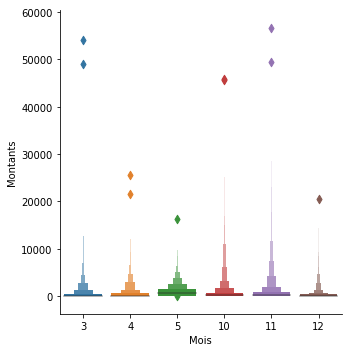

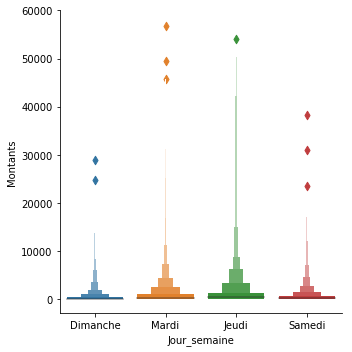

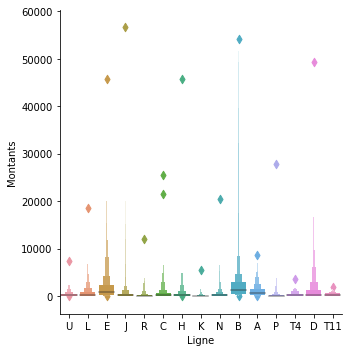

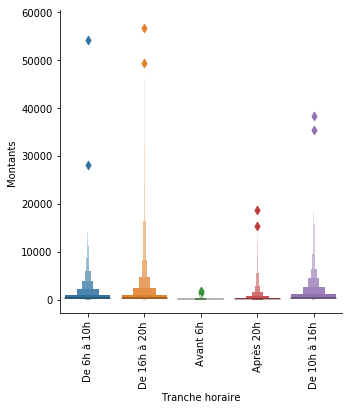

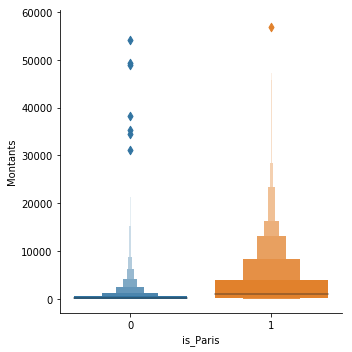

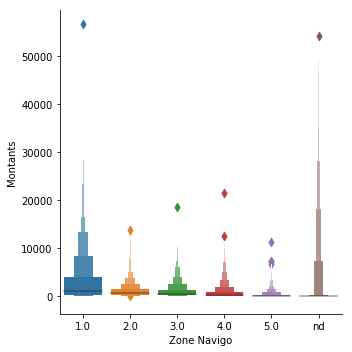

In [10]:
# explorer les données
sns.catplot(x = 'Année', y = 'Montants', kind = 'boxen', data = transilien)
sns.catplot(x = 'Mois', y = 'Montants', kind = 'boxen', data = transilien)
sns.catplot(x = 'Jour_semaine', y = 'Montants', kind = 'boxen', data = transilien)
sns.catplot(x = 'Ligne', y = 'Montants', kind = 'boxen', data = transilien)
sns.catplot(x = 'Tranche horaire', y = 'Montants', kind = 'boxen', data = transilien).set_xticklabels(rotation=90)
sns.catplot(x = 'is_Paris', y = 'Montants', kind = 'boxen', data = transilien)
sns.catplot(x = 'Zone Navigo', y = 'Montants', kind = 'boxen', data = transilien)

## Modélisation du nombre d'usagers

Avant de modéliser le nombre d'usagers du réseau Transilien, il convient de préparer les différents jeux de données : **entrainement, validation, test**. La modélisation s'opère sur le jeu d'entrainement, et est évaluée et ajustée sur le jeu de validation. 

Au préalable, il convient de rappeler que la **variable cible** - le nombre de montants - est **extrêmement dispersée**, avec un écart-type de 2674 usagers, en raison d'un petit nombre de valeurs très élevées, jusqu'à plus de 56 000 usagers, alors même que la moyenne est de 872 usagers et que 50 % des observations sont inférieures à 148 montants. 

Ce petit nombre de valeurs très élevées nous conduit également à choisir de recourir à l'**erreur médiane** comme mesure de performance en plus de l'**erreur moyenne**. En effet, cette dernière ne devrait pas pouvoir correctement synthéthiser la qualité des prédictions car la présence de valeurs extrêmes conduit à ce que quelques prédictions soient très éloignées de la valeur réelle, entrainant une erreur très forte et pénalisant donc l'appréciation globale de la qualité du modèle. La médiane est au contraire résistante aux valeurs extrêmes, donc aux erreurs extrêmes, ce qui permet de mieux refléter la qualité globale de la modélisation.

count     7152.000000
mean       872.782578
std       2674.809822
min          0.000000
25%         26.000000
50%        148.000000
75%        656.000000
max      56728.000000
Name: Montants, dtype: float64
La médiane de la variable cible est :  148.0


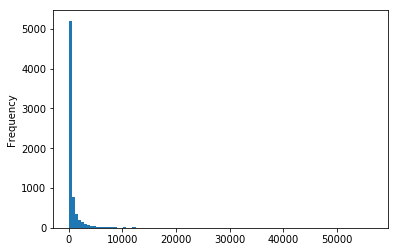

In [11]:
# préparer les jeux de données
Target = transilien['Montants']
print(Target.describe()) 
print('La médiane de la variable cible est : ', Target.median()) # 148
Target.plot.hist(bins = 100)

transilien.drop(columns = ['Montants'], inplace=True)

# créer les variables binaires
predictors = pd.get_dummies(transilien)

# créer le jeu d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(predictors, Target, test_size=0.2, random_state=15)

# couper le jeu d'entrainement en un jeu d'entrainement et un jeu de validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

La forte dispersion de la variable cible - le nombre de montants - nous incite à la transformer avec son **logarithme naturel**, d'entrainer le modèle puis de prédire les valeurs du jeu de validation, enfin de transformer ces prédictions avec la fonction **exponentielle** afin de retrouver l'unité de mesure de départ. 

Suivant ce protocole, une régression linéaire permet de prédire en moyenne le nombre d'usagers à 454 personnes près mais, **dans 50 % des cas, l'erreur est de moins de 49 personnes**. L'écart très important entre l'erreur moyenne et l'erreur médiane confirme la présence des quelques valeurs très élevées et l'utilité de recourir à cette seconde mesure de performance. 

In [12]:
# régression linéaire avec le logarithme naturel
y_train_log = y_train + 1 
y_train_log = np.log(y_train_log)
reg_log = LinearRegression().fit(X_train, y_train_log)
y_train_pred = reg_log.predict(X_train)
print('Erreur moyenne sur le jeu d\'entrainement : ', mean_absolute_error(y_train, np.exp(y_train_pred))) # 369
print('Erreur médiane sur le jeu d\'entrainement : ', median_absolute_error(y_train, np.exp(y_train_pred))) # 49

y_val_pred = reg_log.predict(X_val)
y_val_pred = pd.DataFrame(np.exp(y_val_pred))
y_val_pred = y_val_pred.replace(np.inf, 660)
y_val_pred.describe()
print('Erreur moyenne sur le jeu de validation : ', mean_absolute_error(y_val,y_val_pred)) # 454
print('Erreur médiane sur le jeu de validation : ', median_absolute_error(y_val, y_val_pred)) # 49

Erreur moyenne sur le jeu d'entrainement :  368.71130935269474
Erreur médiane sur le jeu d'entrainement :  48.962763645189156
Erreur moyenne sur le jeu de validation :  453.9375692376763
Erreur médiane sur le jeu de validation :  48.703160760245254


D'autres algorithmes ont été essayés, notamment une forêt aléatoire et un *light gradient boosting machine*, mais ils n'ont pas apporté de meilleurs résultats que la régression linéaire.

Il est désormais possible de recréer le jeu d'entrainement complet (c'es-à-dire incluant le jeu ayant servi pour la validation), d'entraîner le modèle et de l'évaluer sur le jeu de test. En moyenne, on obtient que le modèle prédit à 428 personnes près le nombre d'usagers du Transilien mais que **dans 50 % des cas, l'erreur est inférieure à 52 personnes**, et dans 75 % des cas l'erreur est de moins de 263 personnes, ce qui en fait une modélisation convenable compte tenu du petit nombre d'observations dans le jeu de données.

In [13]:
# recréer le jeu d'entrainement et le jeu de test
X_train, X_test, y_train, y_test = train_test_split(predictors, Target, test_size=0.2, random_state=15)

In [14]:
# régression linéaire avec le logarithme naturel
y_train_log = y_train + 0.1 
y_train_log = np.log(y_train_log)
reg_log = LinearRegression().fit(X_train, y_train_log)
y_train_pred = reg_log.predict(X_train)
print('Erreur moyenne sur le jeu d\'entrainement : ', mean_absolute_error(y_train, np.exp(y_train_pred))) # 390
print('Erreur médiane sur le jeu d\'entrainement : ', median_absolute_error(y_train, np.exp(y_train_pred))) # 48

y_test_pred = reg_log.predict(X_test)
print('Erreur moyenne sur le jeu de test : ', mean_absolute_error(y_test, np.exp(y_test_pred))) # 428
print('Erreur médiane sur le jeu de test : ', median_absolute_error(y_test, np.exp(y_test_pred))) # 52

Erreur moyenne sur le jeu d'entrainement :  389.5755265994383
Erreur médiane sur le jeu d'entrainement :  48.38317426677568
Erreur moyenne sur le jeu de test :  428.14521133771893
Erreur médiane sur le jeu de test :  52.51475485198003


In [15]:
y_test_pred =  np.exp(y_test_pred)
erreur = y_test - y_test_pred
erreur = np.abs(erreur)
erreur.describe()

count     1431.000000
mean       428.145211
std       1643.051332
min          0.013586
25%         11.234015
50%         52.514755
75%        263.123752
max      33279.164019
Name: Montants, dtype: float64